# Import

In [1]:
!pip install attacut

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
from pythainlp.corpus.common import thai_stopwords
from pythainlp import word_tokenize
from sklearn.model_selection import train_test_split     ## import train & test splitting library from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.naive_bayes import CategoricalNB   ,BernoulliNB , MultinomialNB  ## Bernoulli Naive Bayes
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score
import joblib
import re
import numpy as np

# Read

In [3]:
df = pd.read_json("./thai_sentiment_dataset.json")
df = df.drop_duplicates()

In [4]:
df.sample(5)

,story,sentiment
11299,ถ้ายุคก่อนมีชัคกี้ ยุคนี้ก็คงต้องเป็นเมแกนที่ค...,negative
11294,สระแก้ว - ปลัดอำเภอสนามชัยเขต จ.ฉะเชิงเทรา 2 ค...,negative
4831,ข่าวและการแถลงข่าวในประเทศไทย | News & Press R...,positive
25990,#เงินเฟ้อ #ทันหุ้น –บล.กสิกรไทยระบุว่า อัตราเง...,neutral
13700,วันที่ 7 พ.ย.66 กรมอุตุนิยมวิทยา พยากรณ์ฝนสะสม...,negative


# ดูอัตราส่วน label
ค่อนข้างเท่ากันจึงไม่ downsample

<Axes: xlabel='sentiment'>

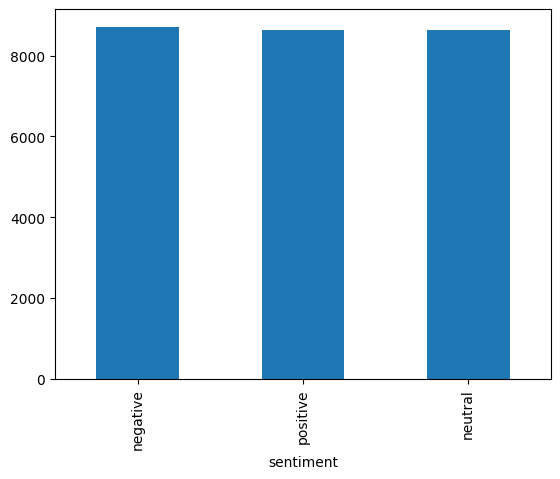

In [5]:
df['sentiment'].value_counts().plot.bar()

# Cleaning
remove everything else except word with length > 1

In [6]:

stopwords = list(thai_stopwords())
print(len(stopwords))
def text_process(text):                                          ###  split word and text preprocessing
    final = re.sub(r'[^a-zA-Z\sก-๛]', '', text, flags=re.UNICODE)
    final = "".join(u for u in final if u not in ("?", ".", ";", ":", "!", '"', "ๆ", "ฯ"))
    final = word_tokenize(final, engine="newmm")
    final = " ".join(word for word in final)
    final = " ".join(word for word in final.split() if word.lower() not in stopwords and len(word) > 1)
    return final.lower()

1030


In [7]:
df['text_tokens'] = df['story'].apply(text_process)
df

,story,sentiment,text_tokens
0,นายสุริยะจึงรุ่งเรืองกิจ รัฐมนตรีว่าการกระทรวง...,positive,สุริยะ รุ่งเรือง กิจ รัฐมนตรี ว่าการ กระทรวงคม...
1,"สวยงามยิ่งนัก กับเพชรเม็ดงามที่หายากยิ่ง ""บลูไ...",positive,สวยงาม เพชร เม็ด งาม หา บลู ได มอนด์ พย สำนักง...
2,"โดยระหว่างวันดัชนีทำจุดสูงสุดที่ 1,417.16 จุด ...",positive,ดัชนี ทำ จุดสูงสุด จุด ทำ จุด ต่ำสุด จุด อันดั...
3,## ประเทศไทยนำเข้าปุ๋ยปีละกว่าแสนล้านบาท ซึ่งห...,positive,ประเทศ ไทย นำเข้า ปุ๋ย ปี แสน ล้าน บาท ผลิต แม...
4,"""เจเอเอส แอสเซ็ท (J)"" โชว์กำไร Q3/66 ทะยาน 617...",positive,เจ เอ เอส แอ เซ็ท โชว์ กำไร ทะยาน โครง การพัฒน...
...,...,...,...
26995,แชร์ :\n\n \n \n \n \n\n\nคุณวิภาวรรณ มหาด...,neutral,แชร์ วิภา วรรณ มหา ดำ รงค์ กุล กรรมการผู้จัดกา...
26996,นายธนวัฒน์ กิตติสุวรรณ ผู้ช่วยผู้จัดการใหญ่ ผู...,neutral,ธน วัฒน์ กิตติ สุวรรณ ผู้ช่วย ผู้จัดการ ผู้บริ...
26997,Advertisement\n\n \n\n\nมติ 'ก้าวไกล' ขับ 'ไช...,neutral,advertisement มติ ก้าวไกล ขับ ไช ยาม วาน พ้น พ...
26998,วันที่ 7 พฤศจิกายน 2566 เวลา 09.00 น. นายไพโร...,neutral,วันที่ พฤศจิกายน เวลา ไพโรจน์ โชติก เสถียร ปลั...


# Extract feature by countvectorizer

In [8]:
count_vector = CountVectorizer(token_pattern="[\S]+")
#count_vector = TfidfVectorizer(token_pattern="[\S]+",smooth_idf=True,use_idf=True)

Y = df['sentiment']
X = df['text_tokens']
X = count_vector.fit_transform(X)   
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2,stratify=Y, random_state=42)
print("Vocab size " ,len(count_vector.vocabulary_))

Vocab size  65786


In [9]:
vocab = list(count_vector.vocabulary_.items())      # For furthur inspection in jupyter
print(len(count_vector.vocabulary_))

65786


# Naive bay model test

In [10]:
clf = MultinomialNB()
clf.fit(X_train, Y_train)
acc = clf.score(X_test,Y_test)
print("Accuracy on test : ",acc)

Accuracy on test :  0.6319938473370506


# LogisticRegression model test

In [11]:
softmax_regression_model = LogisticRegression(multi_class='multinomial',max_iter=1000000,n_jobs=4)
softmax_regression_model.fit(X_train, Y_train)
acc2 = softmax_regression_model.score(X_test,Y_test)
print("Accuracy on test : ",acc2)

Accuracy on test :  0.7375504710632571


# Hyper parameter tuning on RandomForestClassifier

In [12]:
# max_depth=125, n_estimators=200, n_jobs=4)
param_grid = {
    'n_estimators':list(range(180,240,4)), #[50,100,150,200,225,250],
    'max_depth':list(range(100,150,3)), # [50, 75, 100,112, 125, 150, 175,200],
    'max_features': ["sqrt",None]
}

# Initialize the RandomForestClassifier
forest_model = RandomForestClassifier(random_state=1, n_jobs=-1)

# Initialize RandomizedSearchCV with the custom scorer
# This already do cross validation on given data!
tuner = HalvingGridSearchCV(estimator=forest_model, param_grid=param_grid, verbose=1,n_jobs=-1)

# Fit the tuner on the training data
tuner.fit(X_train, Y_train)

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 85
max_resources_: 20800
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 510
n_resources: 85
Fitting 5 folds for each of 510 candidates, totalling 2550 fits
----------
iter: 1
n_candidates: 170
n_resources: 255
Fitting 5 folds for each of 170 candidates, totalling 850 fits
----------
iter: 2
n_candidates: 57
n_resources: 765
Fitting 5 folds for each of 57 candidates, totalling 285 fits
----------
iter: 3
n_candidates: 19
n_resources: 2295
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 6885
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 5
n_candidates: 3
n_resources: 20655
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
                    n_jobs=-1,
                    param_grid={'max_depth': [100, 103, 106, 109, 112, 115, 118,
                                              121, 124, 127, 130, 133, 136, 139,
                                              142, 145, 148],
                                'max_features': ['sqrt', None],
                                'n_estimators': [180, 184, 188, 192, 196, 200,
                                                 204, 208, 212, 216, 220, 224,
                                                 228, 232, 236]},
                    verbose=1)

In [13]:
# Results
print("Best parameters:", tuner.best_params_)
print("Best score on val data:", tuner.best_score_)
cv_result = pd.DataFrame(tuner.cv_results_).sort_values("rank_test_score")
cv_result

Best parameters: {'max_depth': 115, 'max_features': 'sqrt', 'n_estimators': 208}
Best score on val data: 0.745436940208182


,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
764,5,20655,311.095769,8.568190,0.995882,0.028600,115,sqrt,208,"{'max_depth': 115, 'max_features': 'sqrt', 'n_...",...,0.745437,0.005109,1,0.991043,0.991164,0.991588,0.990438,0.990257,0.990898,0.000488
765,5,20655,251.305052,43.537917,0.691063,0.270157,115,sqrt,200,"{'max_depth': 115, 'max_features': 'sqrt', 'n_...",...,0.744662,0.005580,2,0.991225,0.991225,0.991588,0.990620,0.990015,0.990934,0.000555
763,5,20655,288.227366,5.086026,0.886174,0.106922,115,sqrt,192,"{'max_depth': 115, 'max_features': 'sqrt', 'n_...",...,0.743936,0.004556,3,0.991164,0.991104,0.991649,0.990620,0.990196,0.990947,0.000497
761,4,6885,70.275048,9.571850,0.459689,0.024824,115,sqrt,200,"{'max_depth': 115, 'max_features': 'sqrt', 'n_...",...,0.655483,0.009520,4,0.992012,0.994916,0.994916,0.994735,0.993282,0.993972,0.001156
759,4,6885,91.221624,3.955272,0.549844,0.074380,115,sqrt,208,"{'max_depth': 115, 'max_features': 'sqrt', 'n_...",...,0.655483,0.010777,5,0.991830,0.994916,0.994916,0.994553,0.993282,0.993900,0.001197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,0,85,0.718580,0.027696,0.055766,0.006685,139,sqrt,220,"{'max_depth': 139, 'max_features': 'sqrt', 'n_...",...,0.352941,0.134138,733,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
430,0,85,0.711554,0.017839,0.058547,0.011302,142,sqrt,220,"{'max_depth': 142, 'max_features': 'sqrt', 'n_...",...,0.352941,0.134138,733,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
218,0,85,0.690104,0.016225,0.054161,0.004474,121,sqrt,212,"{'max_depth': 121, 'max_features': 'sqrt', 'n_...",...,0.352941,0.134138,733,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
70,0,85,0.719858,0.021557,0.057206,0.005633,106,sqrt,220,"{'max_depth': 106, 'max_features': 'sqrt', 'n_...",...,0.352941,0.134138,733,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


# Create model from tuned parameter

In [14]:
final_model = RandomForestClassifier(n_jobs=4, max_depth=tuner.best_params_["max_depth"], max_features=tuner.best_params_["max_features"], n_estimators=tuner.best_params_["n_estimators"])
final_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=115, n_estimators=208, n_jobs=4)

# Accuracy measure

In [15]:
y_pred = final_model.predict(X_test)
f1 = f1_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
print("f1",f1,"recall",recall)
# Confusion matrix and its label


f1 0.7607252203983529 recall 0.7612133704712111


# Train with entire dataset

In [16]:
final_model.fit(X,Y)

RandomForestClassifier(max_depth=115, n_estimators=208, n_jobs=4)

## Save and wait for actual test data

In [17]:
joblib.dump(final_model, "./random_forest.joblib",compress=3)

['./random_forest.joblib']